In [2]:
import logging
from lisa.utils import setup_logging
setup_logging()

2019-05-03 17:43:17,973 INFO    : root         : Using LISA logging configuration:
2019-05-03 17:43:17,974 INFO    : root         :   /home/dourai01/Data/Git/lisa/repo/logging.conf


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from lisa.utils import get_nested_key
from lisa.tests.base import TestBundle, ResultBundle
from exekall.engine import ValueDB

# Helpers

In [128]:
def collect_value(db, cls, key_path):
    """
    Collect objects computed for the exekall subexpression
    pointed at by ``key_path``, starting from objects of type ``cls``.
    The path is a list of parameter names that allows locating a node in the graph of an expression.
    The path from z to x is ['param2', 'param']
    x = 3
    y = f(param=x)
    z = g(param2=y)
    """
    data = {}
    for froz_val in db.get_by_type(cls):
        key = get_nested_key(froz_val, key_path)
        data.setdefault(key, []).append(froz_val.value)
    
    return data

def collect_metric(db, metric_name, key_path):
    """
    Collect a given metric and use the exekall's FrozenExprVal that can be found at key_path, starting from the root.
    See the documentation for exekall's public API:
    https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/exekall/public_api.html
    """
    return {
        key: [
            val.metrics[metric_name].data
            for val in val_list
            if metric_name in val.metrics
        ]
        for key, val_list
        in collect_value(db, ResultBundle, key_path).items()
    }

# Load exekall's ValueDB

This notebook is meant for analysing a set of results coming from a test session executed using exekall (potentially via bisector).
Since it only relies on [TestMetric], it can also be used with ResultBundle instances generated directly in a notebook (e.g. using [test_task_placement]), without the intervention of any other tool like exekall.

[TestMetric]: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/kernel_tests.html#lisa.tests.base.TestMetric
[test_task_placement]: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/kernel_tests.html#lisa.tests.scheduler.eas_behaviour.EASBehaviour.test_task_placement

In [125]:
# These ValueDB.pickle.xz files can be found in either:
# 1) exekall's artifact dir
# 2) exported from a bisector's report using:
# bisector report myreport.yml.gz -oexport-db=ValueDB.pickle.xz.
path_map = {
    'juno R0':   'juno-r0.report.ValueDB.pickle.xz',
    'juno R2':   'uno-r2.report.ValueDB.pickle.xz',
    'TC2':       'TC2.report.ValueDB.pickle.xz',
    'hikey 960': 'hikey960.report.ValueDB.pickle.xz',
}

db_map = {board: ValueDB.from_path(path) for board, path in path_map.items()}


juno R0:
sugov:0        : avg=0.55% contrib=76.98%
sshd           : avg=0.24% contrib=14.21%
sugov:1        : avg=0.17% contrib=6.16%
rcu_preempt    : avg=0.12% contrib=2.63%

juno R2:
sshd           : avg=0.22% contrib=55.20%
sugov:0        : avg=0.19% contrib=27.49%
rcu_preempt    : avg=0.08% contrib=13.97%
sugov:1        : avg=0.07% contrib=2.64%

TC2:
sugov:2        : avg=0.84% contrib=70.10%
sugov:0        : avg=0.33% contrib=19.73%
sshd           : avg=0.22% contrib=5.80%
rcu_sched      : avg=0.22% contrib=4.36%

hikey 960:
irq/63-tsensor_: avg=0.30% contrib=45.92%
sshd           : avg=0.16% contrib=40.84%
rcu_preempt    : avg=0.07% contrib=7.21%
sugov:0        : avg=0.07% contrib=5.62%


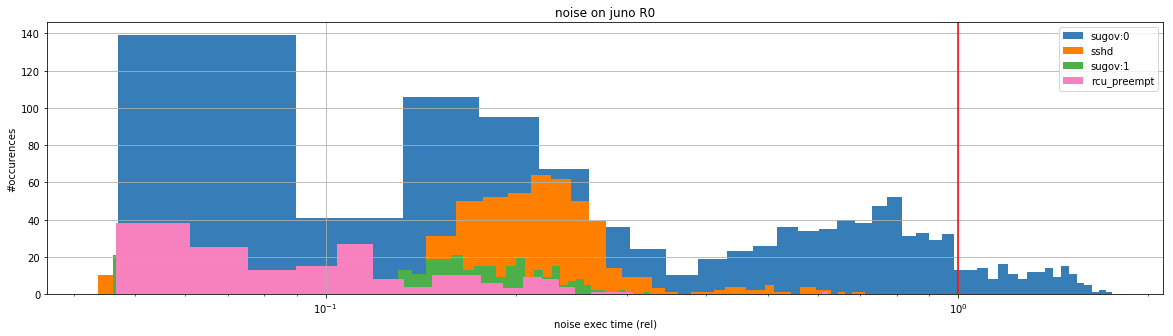

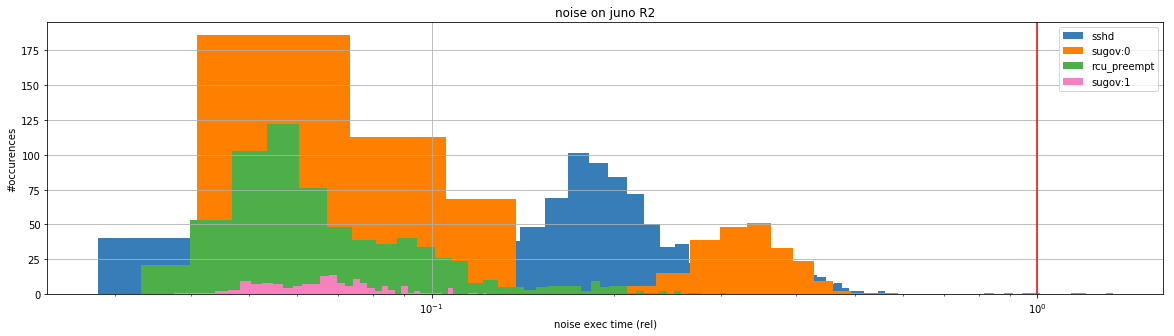

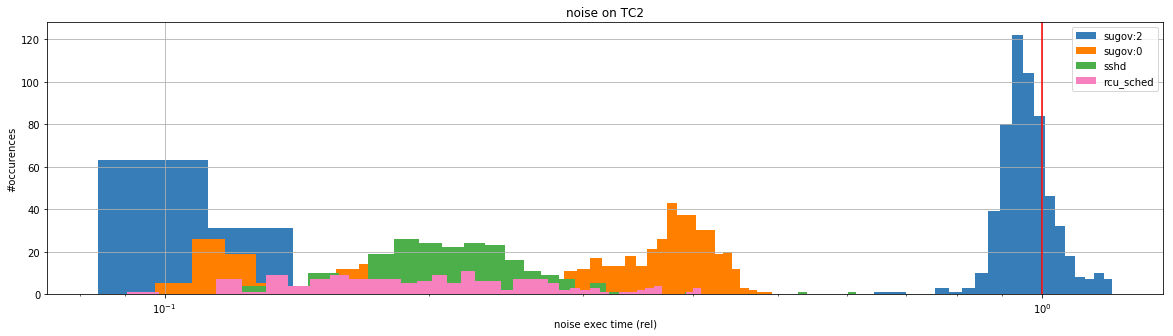

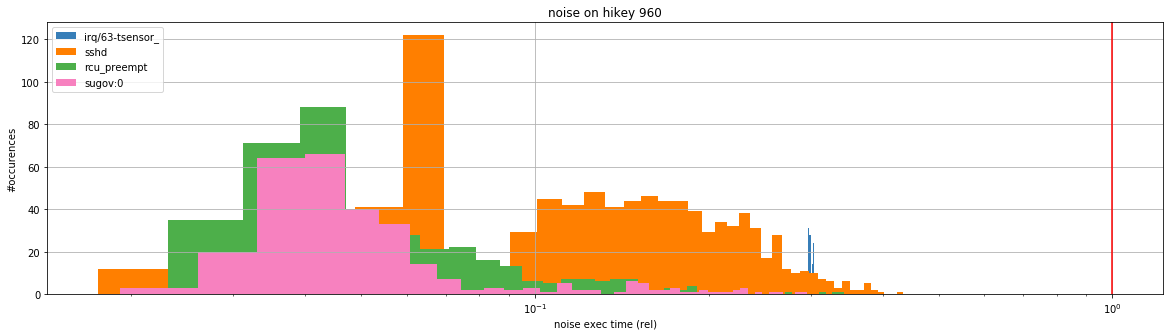

In [130]:
# refer to 'self' parameter of the test method, which is a TestBundle
for board, db in db_map.items():
    print('\n{}:'.format(board))
    
    noisiest_task = collect_metric(db, 'noisiest task', ['self'])
    data = {}
    # Index on the TestBundle to make sure to only have one entry per TestBundle
    for froz_val, metric_list in noisiest_task.items():
        if not metric_list:
            continue
        assert len(metric_list) == 1
        # All noise analysis are done on the same TestBundle, so we can pick any
        metric = metric_list[0]

        # test_bundle = froz_val.value
        # print(froz_val.get_id(qual=False))
        exec_time = metric['duration (rel)'].data
        data.setdefault(metric['comm'], []).append(exec_time)
        
    fig, ax = plt.subplots(figsize=(20, 5))
    # plt.yscale('log')
    plt.xscale('log')

    # Total "noise" time.
    # Ideally, we would like to get the total noise for each trace, but we only have the noisiest task.
    # That approximation should keep relative order in values we compute from it.
    total_noise_time = sum(sum(l) for l in data.values())

    # Check how annoying was that comm. Higher number means it contributed to a lot of traces, or that it had very high contribution to a few traces.
    compute_contrib = lambda exec_time: sum(exec_time) * 100 / total_noise_time

    def key(item):
        comm, exec_time = item
        return compute_contrib(exec_time)

    for comm, exec_time in sorted(data.items(), key=key, reverse=True):
        noise_contribution = compute_contrib(exec_time)
        avg_exec_time = sum(exec_time)/len(exec_time)
        if noise_contribution < 1:
            continue

        series = pd.Series(exec_time)
        series.plot.hist(ax=ax, label=comm, bins=40)

        print('{:<15}: avg={:.2f}% contrib={:.2f}%'.format(comm, avg_exec_time, noise_contribution))

    # Show the usual 1% undecided threshold. Note that some tests may use another threshold,
    # see RTATestBundle.check_noisy_tasks(noise_threshold_pct=XX)
    # https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/kernel_tests.html?highlight=check_noisy_tasks#lisa.tests.base.RTATestBundle.check_noisy_tasks
    ax.axvline(1, color='red')

    ax.set_title('noise on {}'.format(board))
    ax.set_xlabel('noise exec time (rel)')
    ax.set_ylabel('#occurences')
    ax.legend()
    ax.grid(True)